Import Necessary Libraries

In [ ]:
# Data Manipulation and Linear Algebra
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model, neighbors, ensemble, tree

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore')

Loading Data

In [ ]:
data = pd.read_csv("final_test.csv")
data

,weight,age,height,size
0,62,28.0,172.72,XL
1,59,36.0,167.64,L
2,61,34.0,165.10,M
3,65,27.0,175.26,L
4,62,45.0,172.72,M
...,...,...,...,...
119729,63,42.0,175.26,M
119730,45,29.0,154.94,S
119731,61,31.0,172.72,M
119732,74,31.0,167.64,XL


Preprocessing

Checking for Null values

In [ ]:
data.isnull().sum()

weight      0
age       257
height    330
size        0
dtype: int64

In [ ]:
data[["size"]].value_counts()

size
M       29712
S       21924
XXXL    21359
XL      19119
L       17587
XXS      9964
XXL        69
dtype: int64

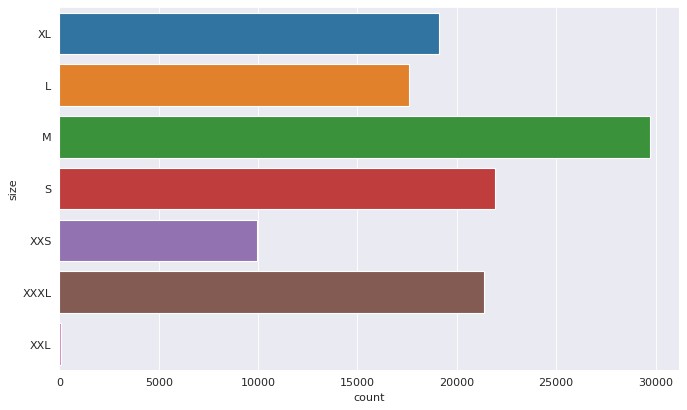

In [ ]:
plt.figure(figsize=(10, 6), dpi=80)
sns.countplot(y=data["size"])
plt.show()

In [ ]:
data.describe()

,weight,age,height
count,119734.000000,119477.000000,119404.000000
mean,61.756811,34.027311,165.805794
std,9.944863,8.149447,6.737651
min,22.000000,0.000000,137.160000
25%,55.000000,29.000000,160.020000
50%,61.000000,32.000000,165.100000
75%,67.000000,37.000000,170.180000
max,136.000000,117.000000,193.040000


Age cannot be 0 so replacing age == 0 with np.nan

In [ ]:
data["age"] = data["age"].replace(0, np.nan)
data["age"] = data["age"].fillna(data["age"].median())

Checking for null values for XXL size

In [ ]:
data[data["size"] == "XXL"].isnull().sum()

weight    0
age       0
height    0
size      0
dtype: int64

Dropping Records with Null Values

Since we have a lot of data we can safely drop records with null values

In [ ]:
data.dropna(inplace=True)
data.isnull().sum()

weight    0
age       0
height    0
size      0
dtype: int64

Reseting the Index

In [ ]:
data.reset_index(drop=True, inplace=True)

EDA

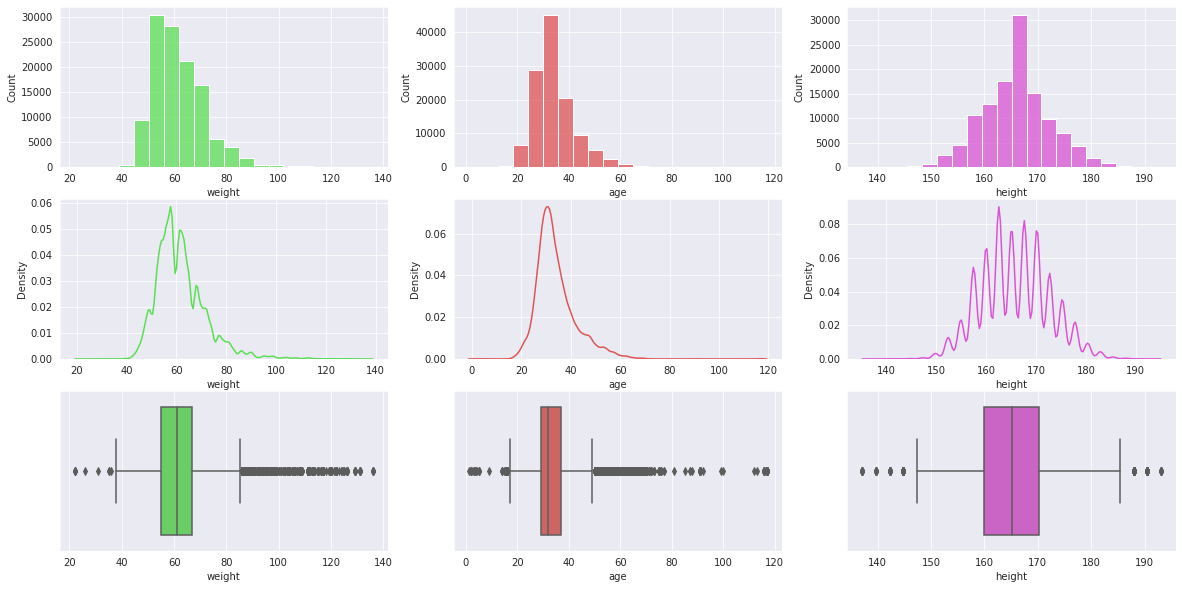

In [ ]:
fig, axes = plt.subplots(figsize=(20, 10), nrows=3, ncols=3)

colors = ["#5bde54","#de5454", "#db53d5"]

# Histograms
col_no = 0
for col in data.columns[:-1]:
    sns.histplot(x=col, data=data, ax=axes[0, col_no], bins=20, color=colors[col_no])
    sns.kdeplot(x=col, data=data, ax=axes[1, col_no], color=colors[col_no])
    sns.boxplot(x=col, data=data, ax=axes[2, col_no], color=colors[col_no])
    col_no += 1

As You can observe from Box Plot there are a lot of outliers
Weight and Age of People is right skewed

In [ ]:
data["size"].value_counts()

M       29638
S       21874
XXXL    21303
XL      19065
L       17529
XXS      9926
XXL        69
Name: size, dtype: int64

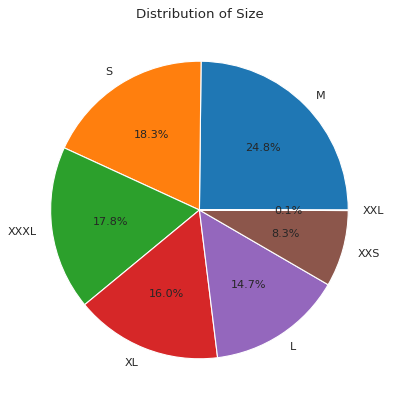

In [ ]:
labels = list(data["size"].value_counts().index)

plt.figure(figsize=(6, 8), dpi=80)
plt.pie(data["size"].value_counts(), autopct='%.1f%%', labels=labels)
plt.title("Distribution of Size")
plt.show()

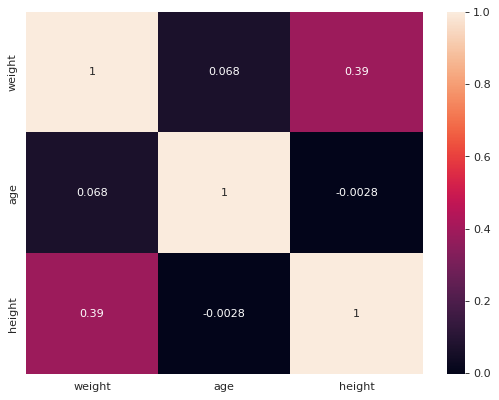

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
sns.heatmap(data.corr(), annot=True)
plt.show()

Bining all Features

In [ ]:
data["height_bins"] = pd.qcut(data["height"], q=6)
data["weight_bins"] = pd.qcut(data["weight"], q=10)
data["age_bins"] = pd.qcut(data["age"], q=10)

data.drop(["weight", "age", "height"], axis=1, inplace=True)
data

,size,height_bins,weight_bins,age_bins
0,XL,"(167.64, 172.72]","(61.0, 63.0]","(26.0, 28.0]"
1,L,"(165.1, 167.64]","(58.0, 61.0]","(34.0, 36.0]"
2,M,"(162.56, 165.1]","(58.0, 61.0]","(32.0, 34.0]"
3,L,"(172.72, 193.04]","(63.0, 65.0]","(26.0, 28.0]"
4,M,"(167.64, 172.72]","(61.0, 63.0]","(39.0, 45.0]"
...,...,...,...,...
119399,M,"(172.72, 193.04]","(61.0, 63.0]","(39.0, 45.0]"
119400,S,"(137.159, 160.02]","(21.999, 52.0]","(28.0, 30.0]"
119401,M,"(167.64, 172.72]","(58.0, 61.0]","(30.0, 31.0]"
119402,XL,"(165.1, 167.64]","(68.0, 74.0]","(30.0, 31.0]"


Preparing Data

Stratified Train Test Split

Evenly Spreading the Dependent Variable "size" in train and test set

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data['size']):
    train = data.loc[train_index]
    test = data.loc[test_index]

In [ ]:
train.shape, test.shape

((95523, 4), (23881, 4))

In [ ]:
X_train = train.drop("size", axis=1)
y_train = train["size"]

X_test = test.drop("size", axis=1)
y_test = test["size"]

OneHotEncoding

In [ ]:
X_train = pd.get_dummies(X_train).values
X_test = pd.get_dummies(X_test).values

Machine Learning - Multiple Model Testing

Dataframe to store all the accuracy scores for Comparison and Analysis

In [ ]:
MLA_compare = pd.DataFrame()

def MLA_testing(MLA, X_train, X_test):
    row_index = 0
    for classifier in MLA:
        # Training The Model
        classifier.fit(X_train, y_train)

        # KFold Accuracies on Training Data
        kfold_accuracy = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, n_jobs=-1)
        
        # Prediction on Testing Data
        y_pred = cross_val_predict(estimator = classifier, X = X_test, y = y_test, cv = 10, n_jobs=-1)
        
        # Accuracy for y_test and y_pred
        classifier_accuracy_score = accuracy_score(y_test, y_pred)

        # Saving Data in Dataframe
        MLA_name = classifier.__class__.__name__
        MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
        MLA_compare.loc[row_index, 'Accuracy Score'] = classifier_accuracy_score*100
        MLA_compare.loc[row_index, 'K-Fold Accuracy'] = kfold_accuracy.mean()*100

        print(MLA_name, "Done")
        row_index+=1

In [ ]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.RandomForestClassifier(n_jobs=-1),
    
    #GLM
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(n_jobs=-1),

    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
]

MLA_testing(MLA=MLA, X_train=X_train, X_test=X_test)

AdaBoostClassifier Done
RandomForestClassifier Done
RidgeClassifierCV Done
SGDClassifier Done
KNeighborsClassifier Done
DecisionTreeClassifier Done
ExtraTreeClassifier Done


Comparing Models

In [ ]:
MLA_compare = MLA_compare.sort_values(by="Accuracy Score", ascending=False).reset_index(drop=True)
MLA_compare

,MLA Name,Accuracy Score,K-Fold Accuracy
0,RandomForestClassifier,48.837988,50.184777
1,DecisionTreeClassifier,48.825426,50.166978
2,ExtraTreeClassifier,48.821239,50.166978
3,RidgeClassifierCV,48.787739,48.458472
4,SGDClassifier,45.994724,46.619140
5,KNeighborsClassifier,44.076881,44.597665
6,AdaBoostClassifier,40.123948,46.701841


Using DecisionTreeClassifier

KFold Accuracies: [0.50078509 0.5077986  0.49429499 0.50659548 0.50052345 0.50062814
 0.50293132 0.4968593  0.50366415 0.50261725]
Mean KFold Accuracy: 0.5016697772332825
['M' 'M' 'M' ... 'S' 'XXXL' 'XXXL']
Accuracy Score: 0.4882542607093505


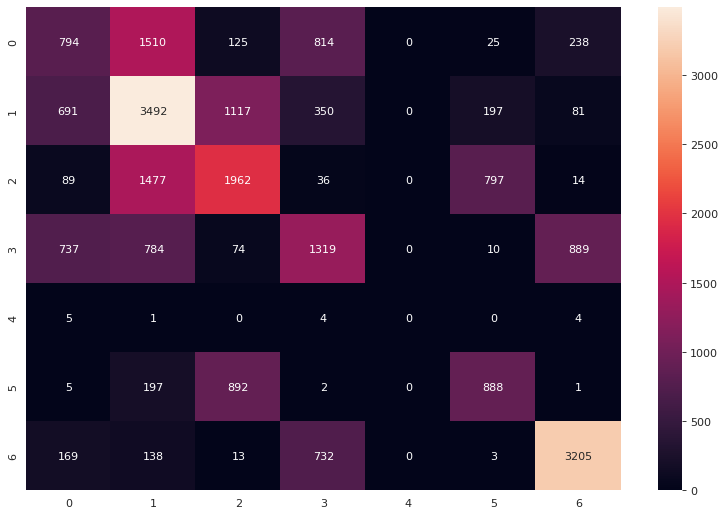

In [ ]:
xgb_clf = tree.DecisionTreeClassifier()

# Training the XGBClassifier
xgb_clf.fit(X_train, y_train)

# KFold Accuracy Score
kfold_accuraies = cross_val_score(xgb_clf, X_train, y_train, cv=10, n_jobs=-1)
print("KFold Accuracies:", kfold_accuraies)
print("Mean KFold Accuracy:", kfold_accuraies.mean())

# Predicting Size for Testing Data
y_pred = cross_val_predict(xgb_clf, X_test, y_test, cv=10, n_jobs=-1)
print(y_pred)

# Accuracy Score
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(12, 8), dpi=80)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.show()